In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv


In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='dark', palette='muted', color_codes=True)
import scipy.stats as st
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

In [3]:
data = pd.read_csv('/kaggle/input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [4]:
data.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [5]:
data.head()

age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   
1  55.0        0                      7861         0                 38   
2  65.0        0                       146         0                 20   
3  50.0        1                       111         0                 20   
4  65.0        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  210000.00               1.9           137    1   
4                    0  327000.00               2.7           116    0   

   smoking  time  DEATH_EVENT  
0        0     4            1  
1        0     6            1  
2        1     7            1  
3        0     7            1  
4        0     8            1

In [6]:
def univariate_numerical(x, color='b', transformed=None):
    f, ax = plt.subplots(nrows=2, ncols=2, figsize=(13,10))
    ax[0,0].set_title(label=f"Distribution of {x.name}")
    sns.distplot(x, ax=ax[0,0], color=color);
    ax[0,1].set_title(label=f"QQ plot for {x.name}")
    st.probplot(x, plot=ax[0,1]);
    sns.boxplot(x, ax=ax[1,0], color=color);
    ax[1,1].set_title(label=f"CDF for {x.name}")
    sns.kdeplot(x, cumulative=True, ax=ax[1,1], color=color)
    f.suptitle(t=f"Univariate Analysis for {x.name}",fontsize=16) if not transformed else f.suptitle(t=f"{transformed} Transformed {x.name}",fontsize=16)
    f.tight_layout();

In [7]:
def univariate_categorical(x, y=None, y_type=None, color='m', transformed=None):
    f, [ax1,ax2,ax3] = plt.subplots(nrows=1, ncols=3, figsize=(16,5))
    ax1.set_title(label=f"category count of {x.name}")
    sns.countplot(x, ax=ax1, color=color);
    if y is not None:
        if y_type=='cat':
            sns.countplot(x, hue=y, ax=ax2)
        else:
            sns.stripplot(x, y, jitter=True, ax=ax2)
        sns.set_style('darkgrid')
        sns.kdeplot(x, y=y, ax=ax3, color=color, cbar=True, shade=True, shade_lowest=False, n_levels=20)
        ax3.set_title(label=f"KDE Plot for {x.name}")
    else:
        sns.boxplot(x, ax=ax2, color=color);
        ax3.set_title(label=f"CDF for {x.name}")
        sns.kdeplot(x, cumulative=True, ax=ax3, color=color)
    f.suptitle(t=f"Univariate Analysis for {x.name}",fontsize=16) if not transformed else f.suptitle(t=f"{transformed} Transformed {x.name}",fontsize=16)
    f.tight_layout();

In [8]:
data.describe()

age     anaemia  creatinine_phosphokinase    diabetes  \
count  299.000000  299.000000                299.000000  299.000000   
mean    60.833893    0.431438                581.839465    0.418060   
std     11.894809    0.496107                970.287881    0.494067   
min     40.000000    0.000000                 23.000000    0.000000   
25%     51.000000    0.000000                116.500000    0.000000   
50%     60.000000    0.000000                250.000000    0.000000   
75%     70.000000    1.000000                582.000000    1.000000   
max     95.000000    1.000000               7861.000000    1.000000   

       ejection_fraction  high_blood_pressure      platelets  \
count         299.000000           299.000000     299.000000   
mean           38.083612             0.351171  263358.029264   
std            11.834841             0.478136   97804.236869   
min            14.000000             0.000000   25100.000000   
25%            30.000000             0.000000  212500.000000   
50%            38.000000             0.000000  262000.000000   
75%            45.000000             1.000000  303500.000000   
max            80.000000             1.000000  850000.000000   

       serum_creatinine  serum_sodium         sex    smoking        time  \
count         299.00000    299.000000  299.000000  299.00000  299.000000   
mean            1.39388    136.625418    0.648829    0.32107  130.260870   
std             1.03451      4.412477    0.478136    0.46767   77.614208   
min             0.50000    113.000000    0.000000    0.00000    4.000000   
25%             0.90000    134.000000    0.000000    0.00000   73.000000   
50%             1.10000    137.000000    1.000000    0.00000  115.000000   
75%             1.40000    140.000000    1.000000    1.00000  203.000000   
max             9.40000    148.000000    1.000000    1.00000  285.000000   

       DEATH_EVENT  
count    299.00000  
mean       0.32107  
std        0.46767  
min        0.00000  
25%        0.00000  
50%        0.00000  
75%        1.00000  
max        1.00000

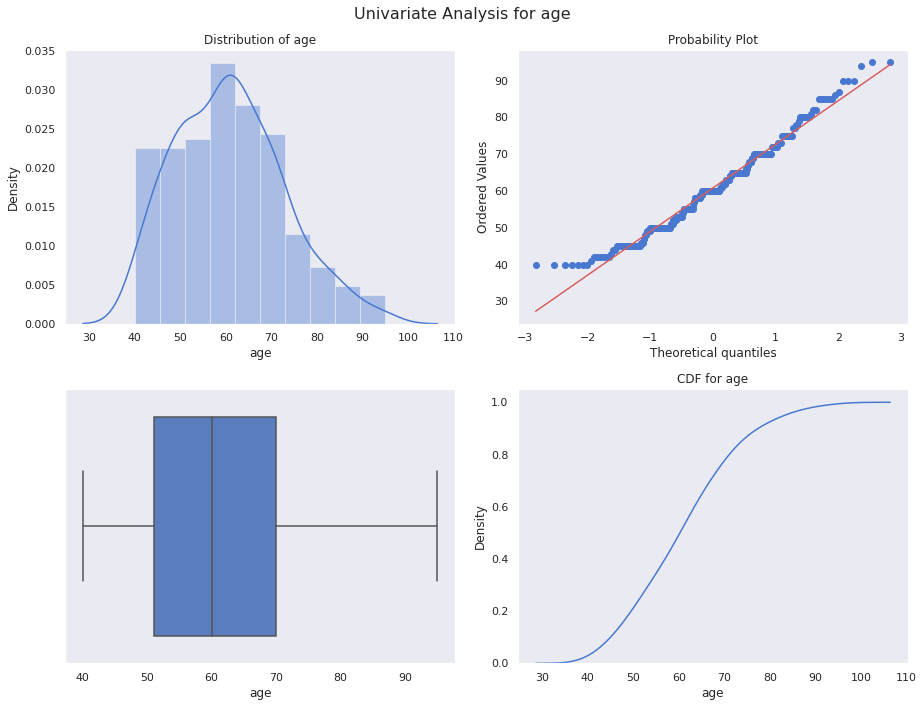

In [9]:
univariate_numerical(data.age);

- No outliers detected.
- The distribution is almost normal but it is ragged.

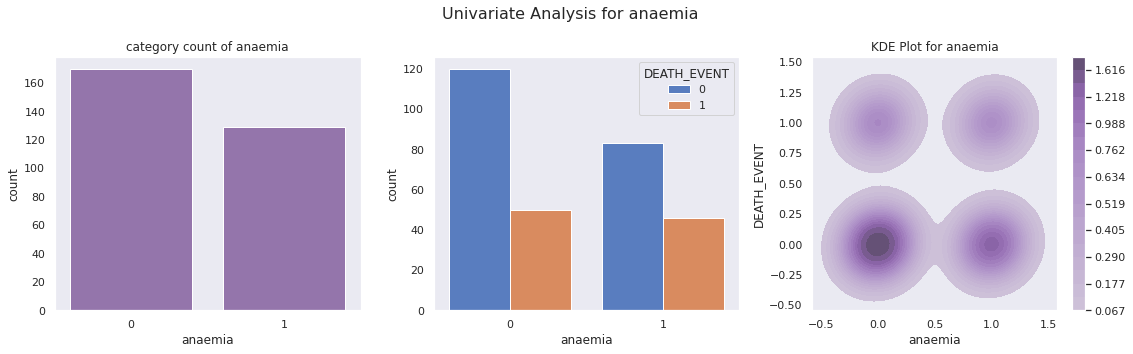

In [10]:
univariate_categorical(x=data.anaemia, y=data.DEATH_EVENT, y_type='cat');

- Anaemia does not have a significant impact on death event.

<h3>creatinine_phosphokinase</h3>

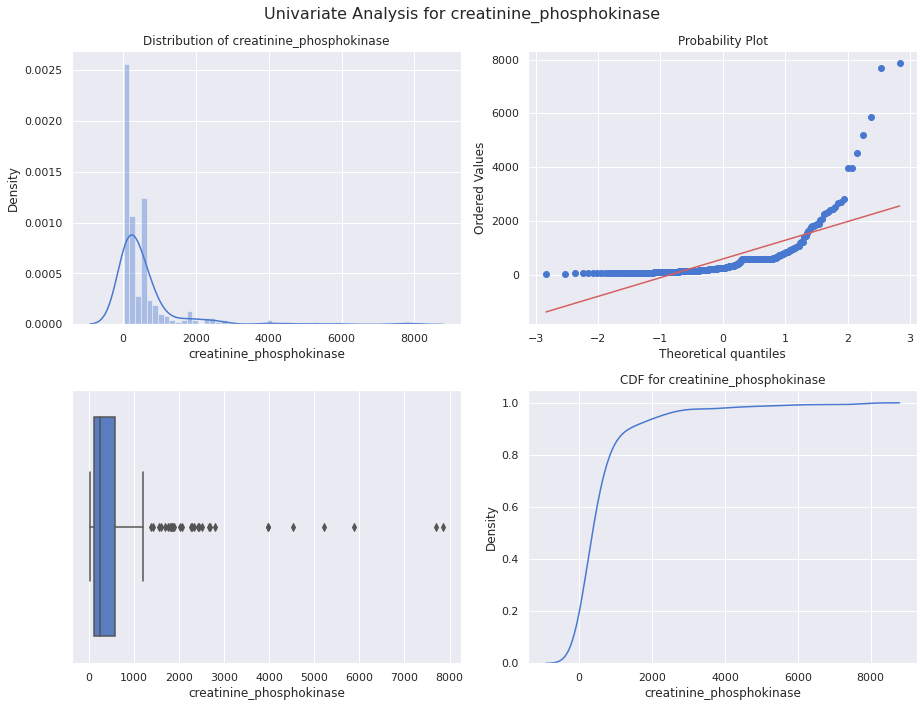

In [11]:
univariate_numerical(data.creatinine_phosphokinase)

- There are many outliers in this variables.
- More than 85% of the data have a value less than or equak to 1000.

In [12]:
def replace_outliers(col, series=True):
    col_repl = col.copy(deep=True)
    q3 = col_repl.quantile(0.75)
    q1 = col_repl.quantile(0.25)
    iqr = q3-q1
    col_repl = col_repl.to_numpy()
    outlierBool = np.where((col_repl < (q1-1.5*iqr))|(col_repl > (q3+1.5*iqr)))
    col_repl[outlierBool] = iqr
    if not series:
        return col_repl
    else:
        return pd.Series(col_repl, name = 'iqr_replaced_'+col.name)

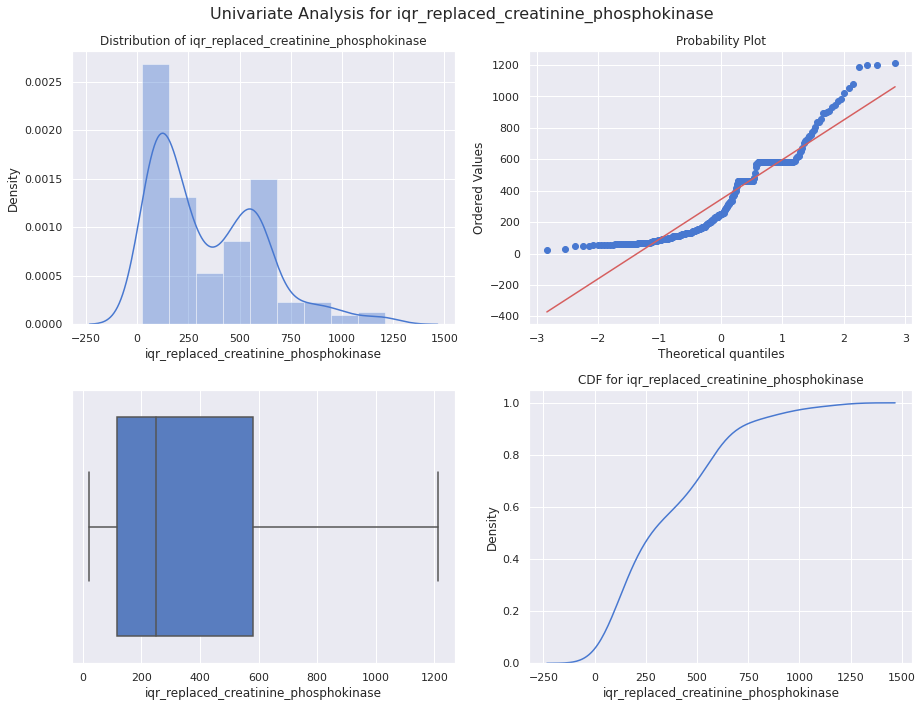

In [13]:
univariate_numerical(replace_outliers(data.creatinine_phosphokinase))

- The data has become bimodal

<h3>Creating a new cat variable -  iqr_replaced_cpk_cat </h3>
<h4> cpk < 345 = 0 </h4>
<h4> cpk > 345 = 1 </h4>

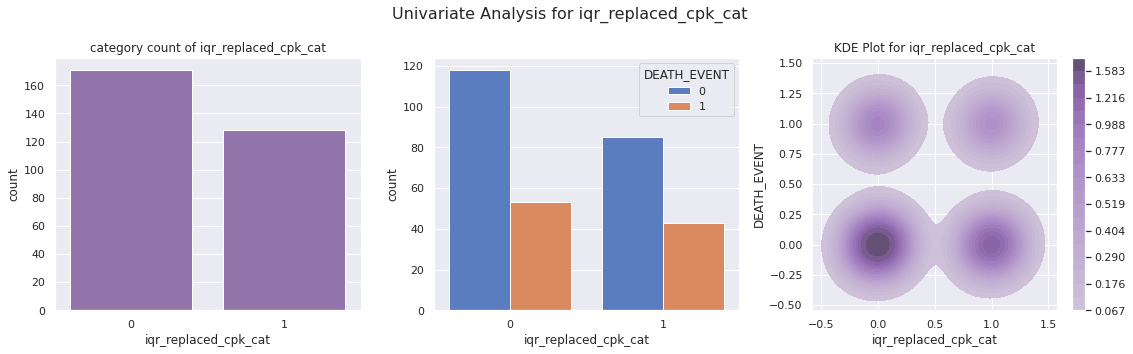

In [14]:
iqr_replaced_cpk = replace_outliers(data.creatinine_phosphokinase)
mean_cpk = iqr_replaced_cpk.mean()
data['iqr_replaced_cpk_cat'] = pd.Series(iqr_replaced_cpk).apply(lambda x: 0 if x <= mean_cpk else 1)
univariate_categorical(x=data.iqr_replaced_cpk_cat, y=data.DEATH_EVENT, y_type='cat')

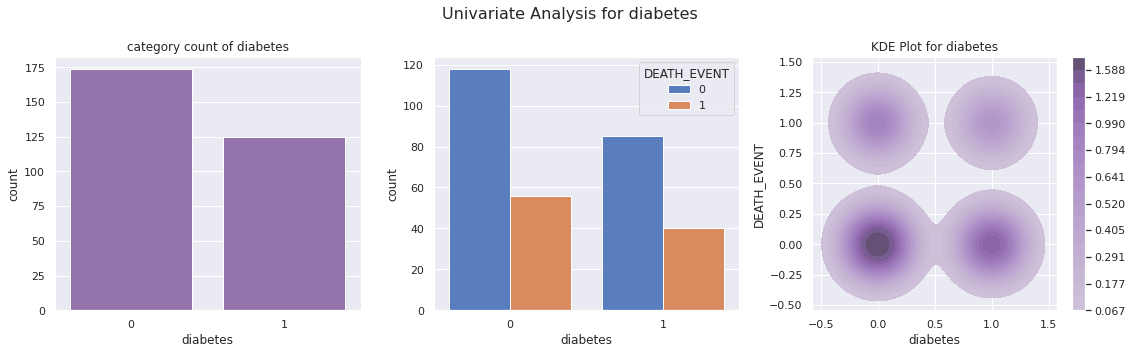

In [15]:
univariate_categorical(x=data.diabetes, y=data.DEATH_EVENT, y_type='cat')

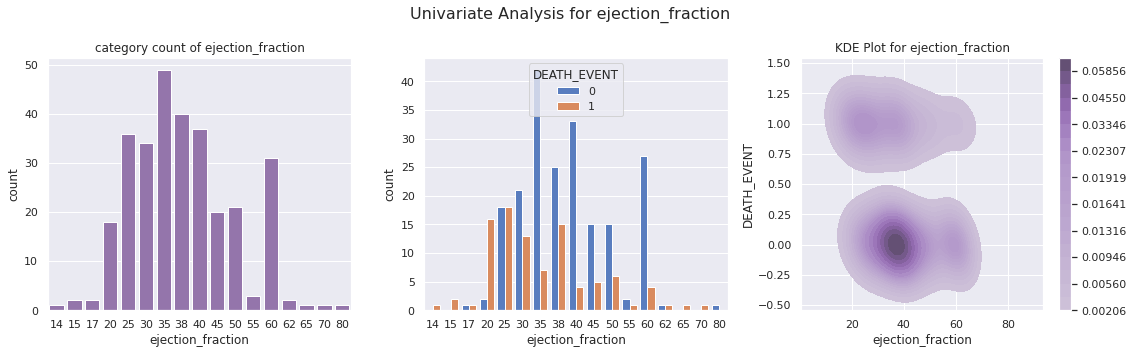

In [16]:
univariate_categorical(x=data.ejection_fraction, y=data.DEATH_EVENT, y_type='cat')

- This is an ordinal variable.
- there are fewer death events for ejection_fraction value > 30 

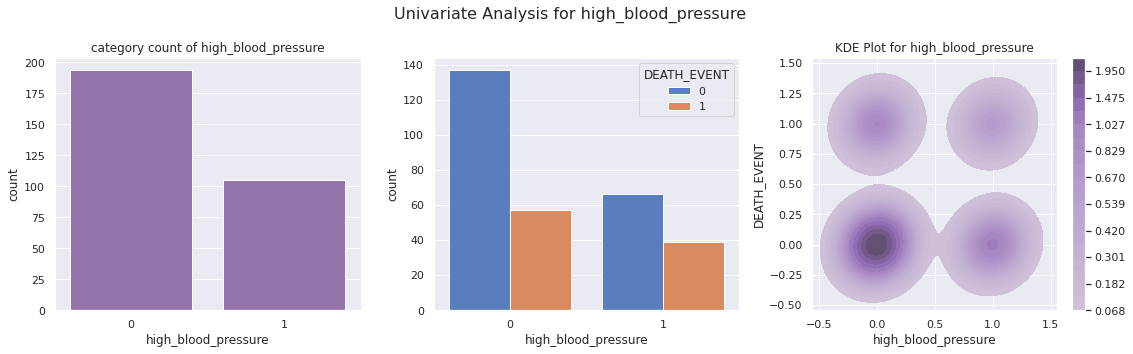

In [17]:
univariate_categorical(x=data.high_blood_pressure, y=data.DEATH_EVENT, y_type='cat')

In [18]:
bp_crosstab= pd.crosstab(index=data.high_blood_pressure, columns=data.DEATH_EVENT)
bp_crosstab

DEATH_EVENT            0   1
high_blood_pressure         
0                    137  57
1                     66  39

In [19]:
print("% deaths with low bp ",bp_crosstab.iloc[0,1]/bp_crosstab.sum(axis=0)[0])
print("% deaths with high bp ",bp_crosstab.iloc[1,1]/bp_crosstab.sum(axis=0)[1])

% deaths with low bp  0.28078817733990147
% deaths with high bp  0.40625


- low BP > high BP
- people with high BT tend to die :P

<h3>Platelets</h3>

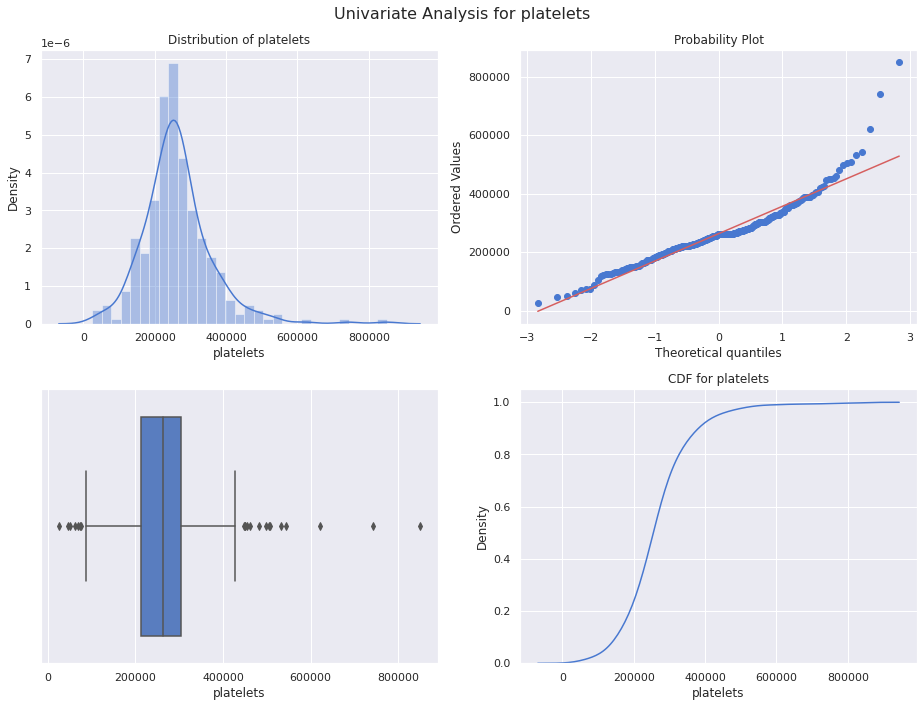

In [20]:
univariate_numerical(data.platelets)

- There are a few outliers.
- The distribution is almost normal. 

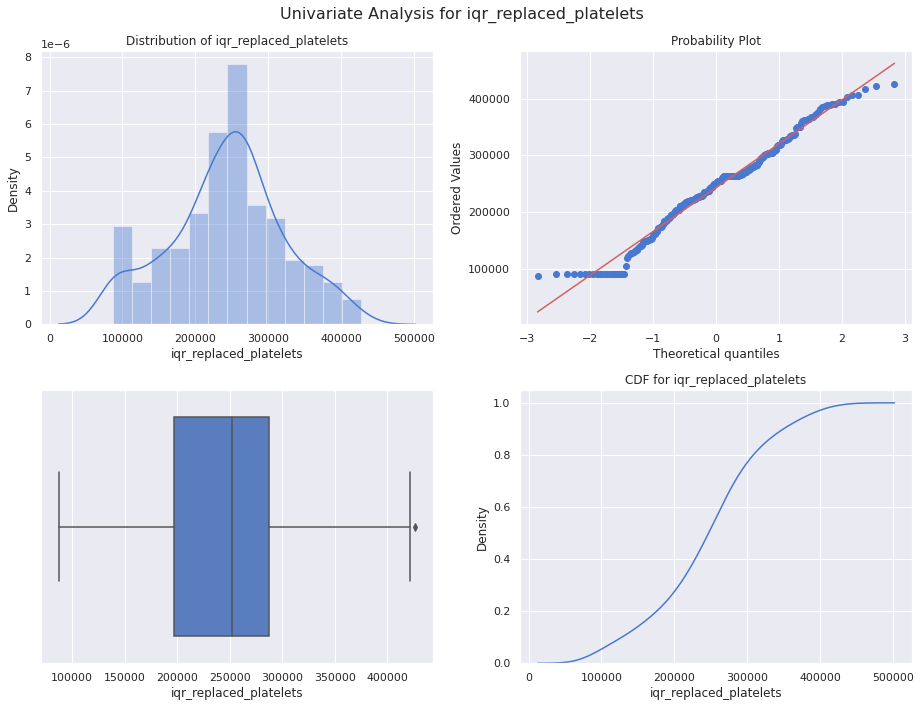

In [21]:
univariate_numerical(replace_outliers(data.platelets))

In [22]:
data['iqr_replaced_platelets'] = replace_outliers(data.platelets)

<h3>Serum_Creatinine</h3>

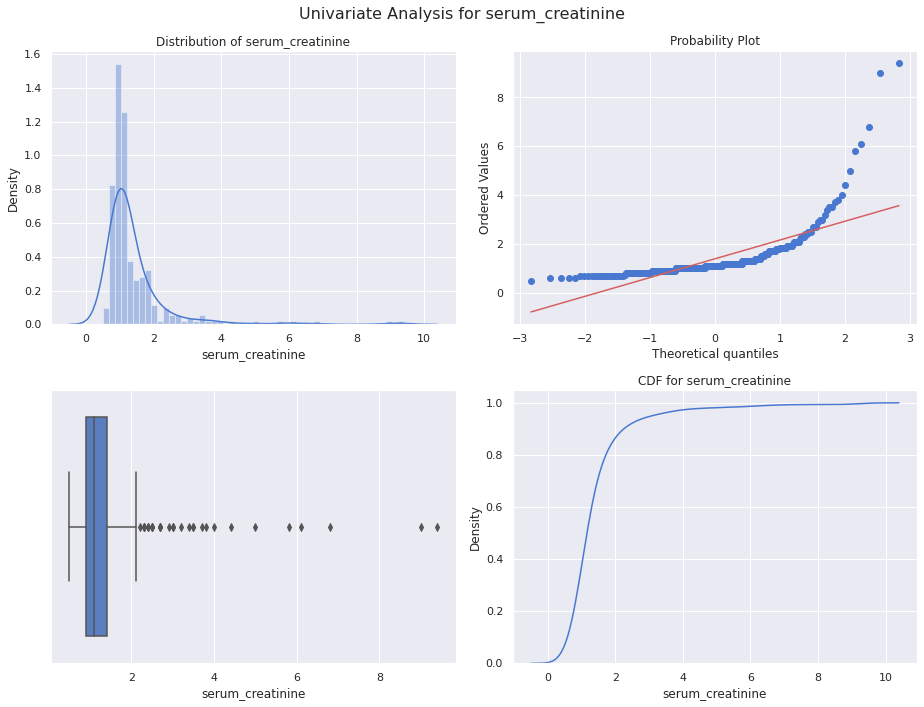

In [23]:
univariate_numerical(data.serum_creatinine)

- Almost 905 of the data is less than 2.
- The distribution is skewed to the right because of outliers.

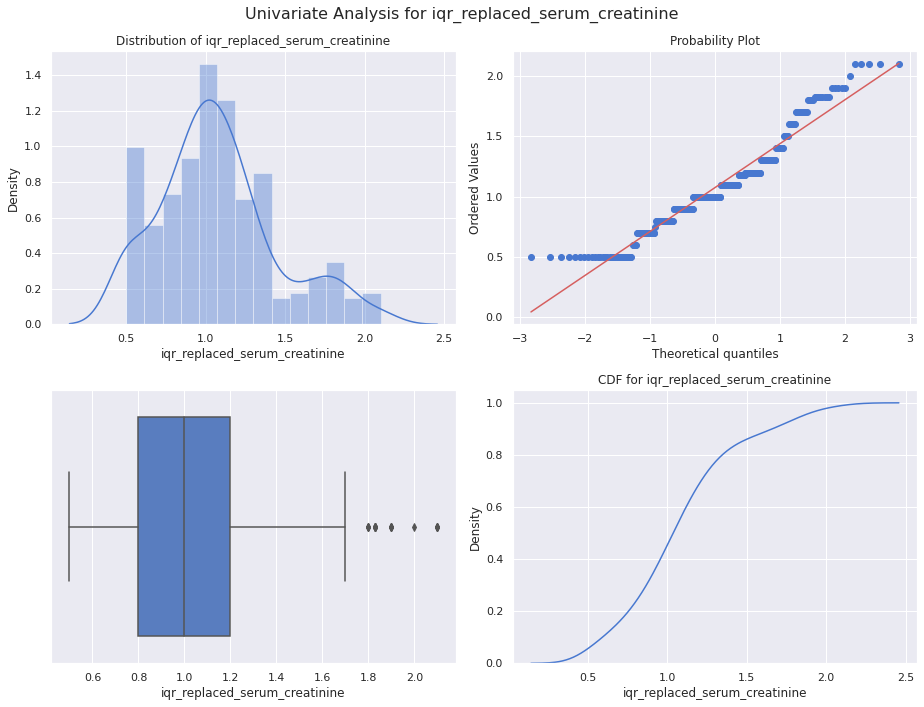

In [24]:
univariate_numerical(replace_outliers(data.serum_creatinine))

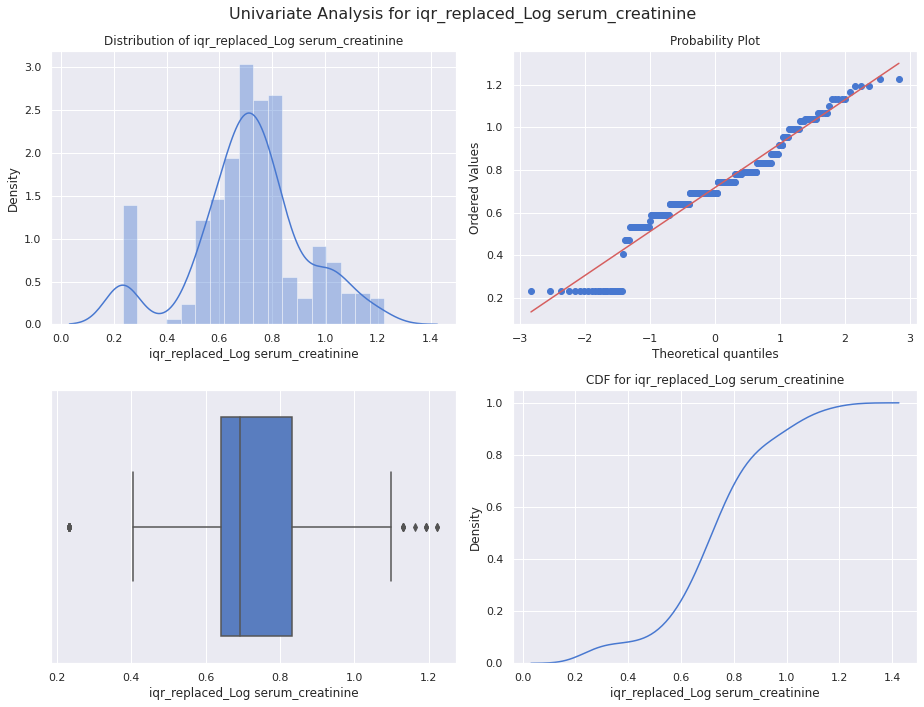

In [25]:
log_transformer = FunctionTransformer(func=np.log1p)
univariate_numerical(replace_outliers(pd.Series(log_transformer.fit_transform(data.serum_creatinine), name='Log serum_creatinine')))

In [26]:
data['tqr_replaced_log_serum_creatinine'] = replace_outliers(pd.Series(log_transformer.fit_transform(data.serum_creatinine), name='Log serum_creatinine'))

<h2>serum_sodium</h2>

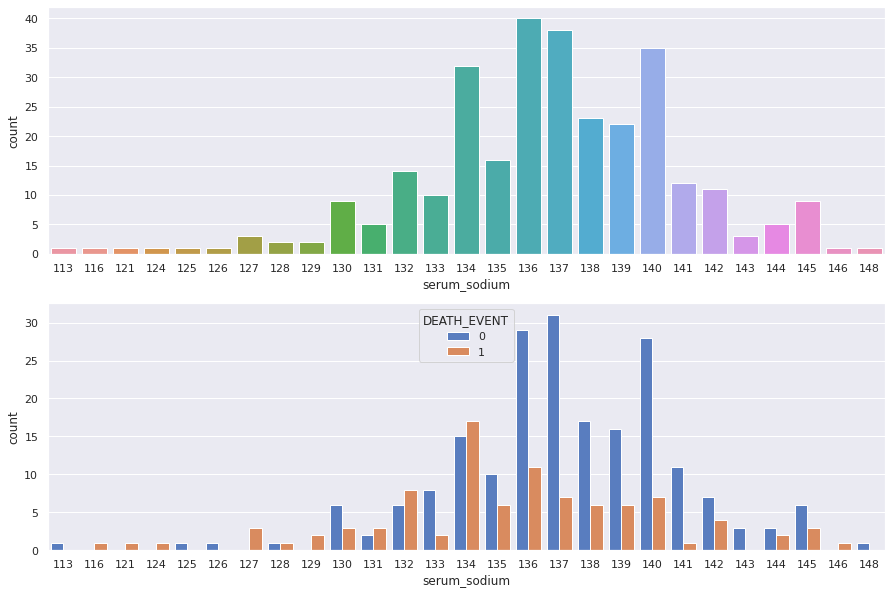

In [27]:
f, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15,10))
sns.countplot(data.serum_sodium, ax=ax1)
sns.countplot(data.serum_sodium, hue= data.DEATH_EVENT, ax=ax2);

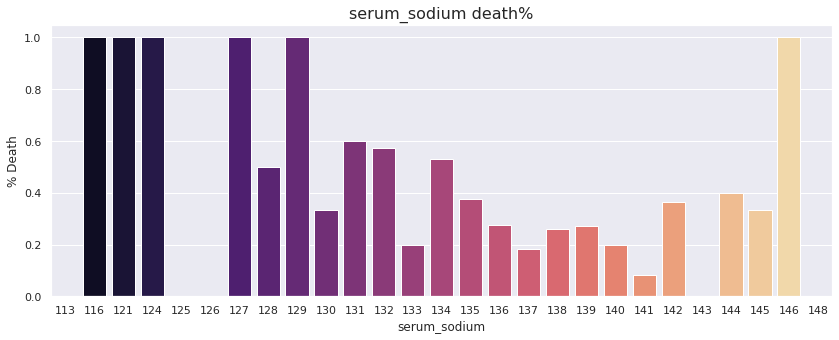

In [28]:
ss = pd.crosstab(index=data['serum_sodium'], columns=data['DEATH_EVENT'])
ss['total'] = ss.sum(axis=1)
ss['% Death'] = np.round(ss[1]/ss['total'], 3)
plt.figure(figsize=(14,5))
sns.barplot(x=ss.index, y=ss['% Death'], palette='magma')
plt.title('serum_sodium death%', fontdict={'size':16});

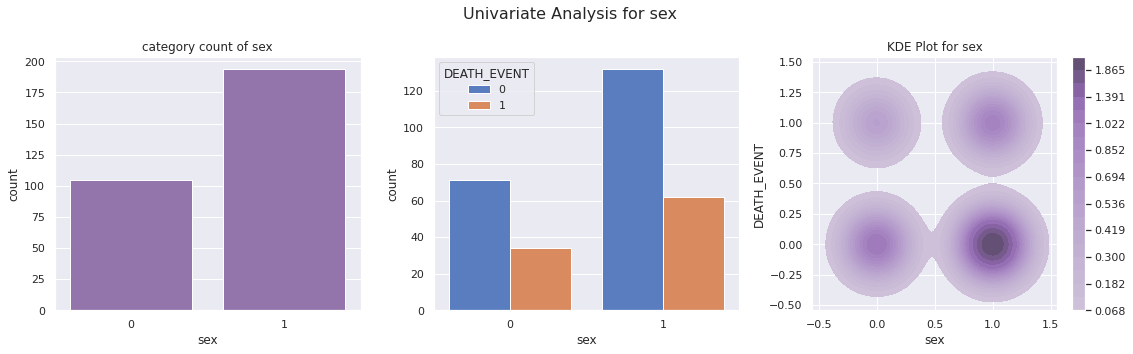

In [29]:
univariate_categorical(x=data.sex, y=data.DEATH_EVENT, y_type='cat')

**1 - Male**;
**0 - Female**

- The dataset is imbalanced.

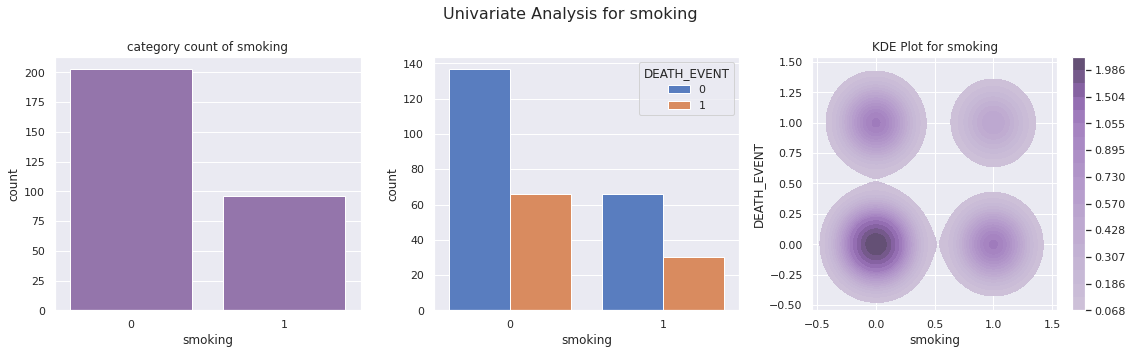

In [30]:
univariate_categorical(x=data.smoking, y=data.DEATH_EVENT, y_type='cat')

- No of non smokers are greater than the no of smokers.
- There seems to be no significant differnce in the death % b/w smokers and non-smokers.

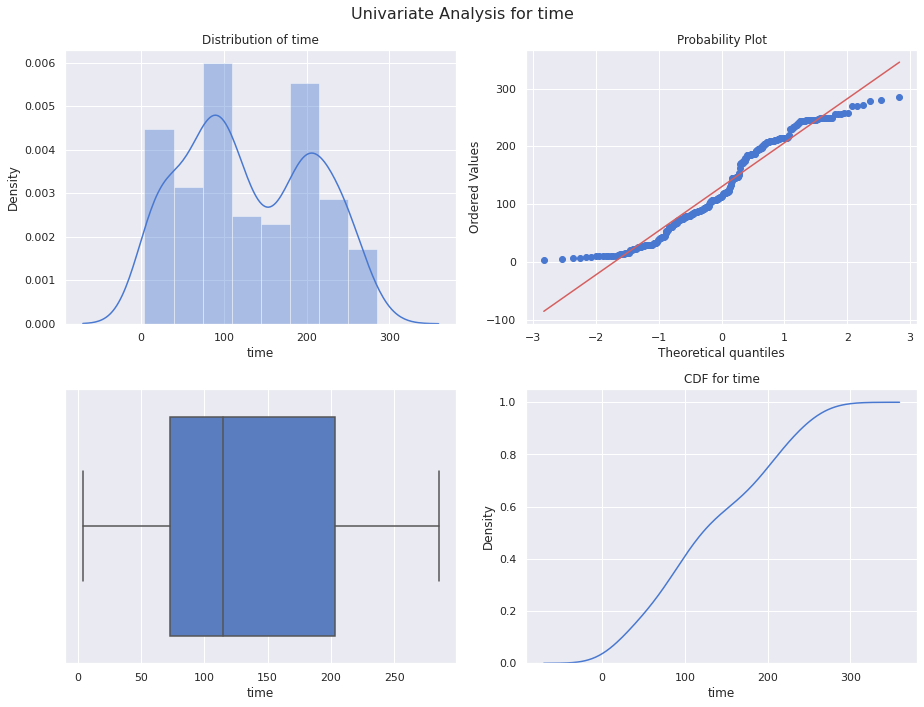

In [31]:
univariate_numerical(data.time)

- The distribution seems to be bimodal.
- The 2 groups are >130.26 and <130.26 (mean)


In [32]:
np.mean(data.time)

130.2608695652174

<h3>Creating new cat feature = time_categorized</h3>
<h4>time < 130.26 = 0</h4>
<h4>time > 130.26 = 1</h4>

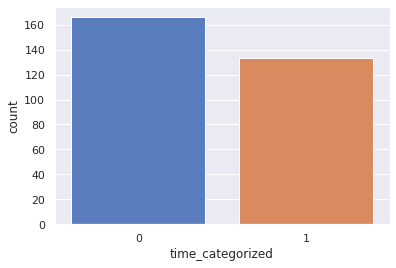

In [33]:
data['time_categorized'] = data['time'].apply(lambda x: 0 if x < 130.26 else 1)
sns.countplot(data.time_categorized);

<h3>Analyzing the dependent variable</h3>

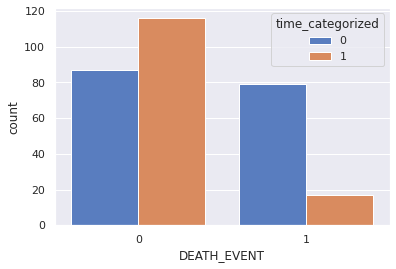

In [34]:
sns.countplot(data.DEATH_EVENT, hue=data.time_categorized);

- The number of people who did not die dominate the dataset.
- People who did not die had greater follow up times. 

# BiVariate Analysis

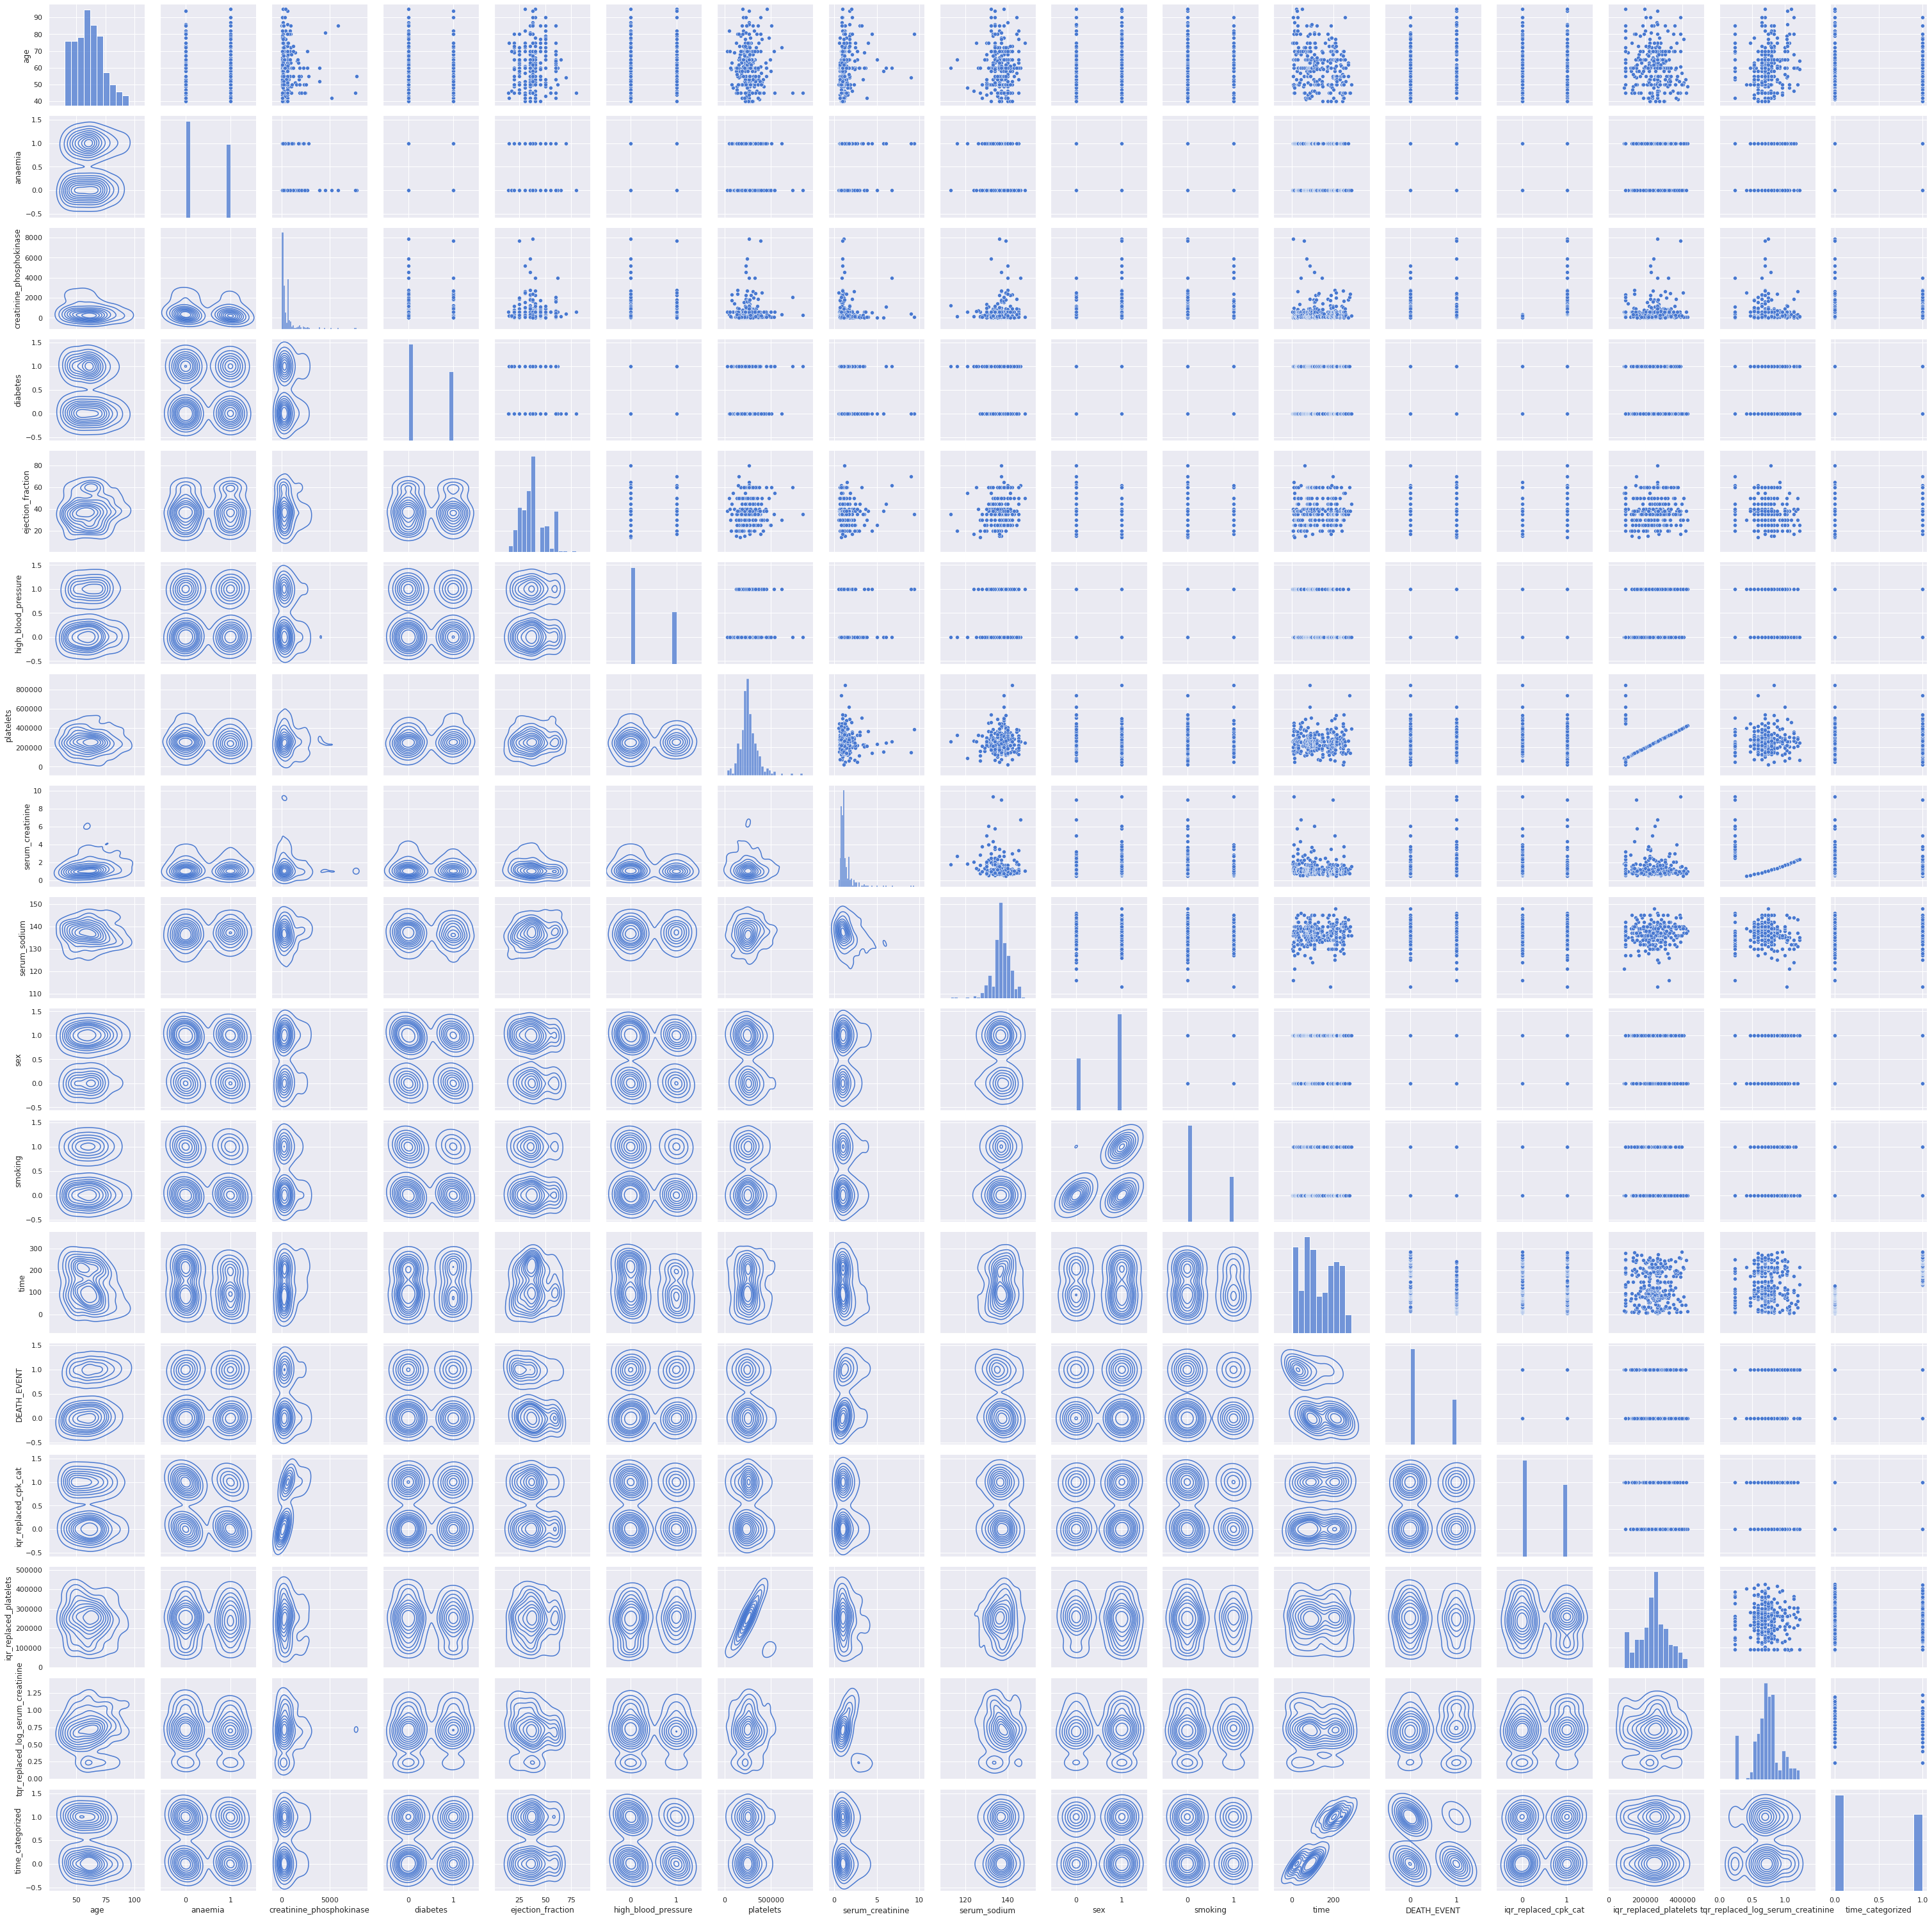

In [35]:
g = sns.PairGrid(data, diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_diag(sns.histplot)
g.map_upper(sns.scatterplot);

- There are less females who smoke.
- If the patient has high BP, the probability that he/she is also diabetic is less.
- most of the people who did not die, had greater followup time

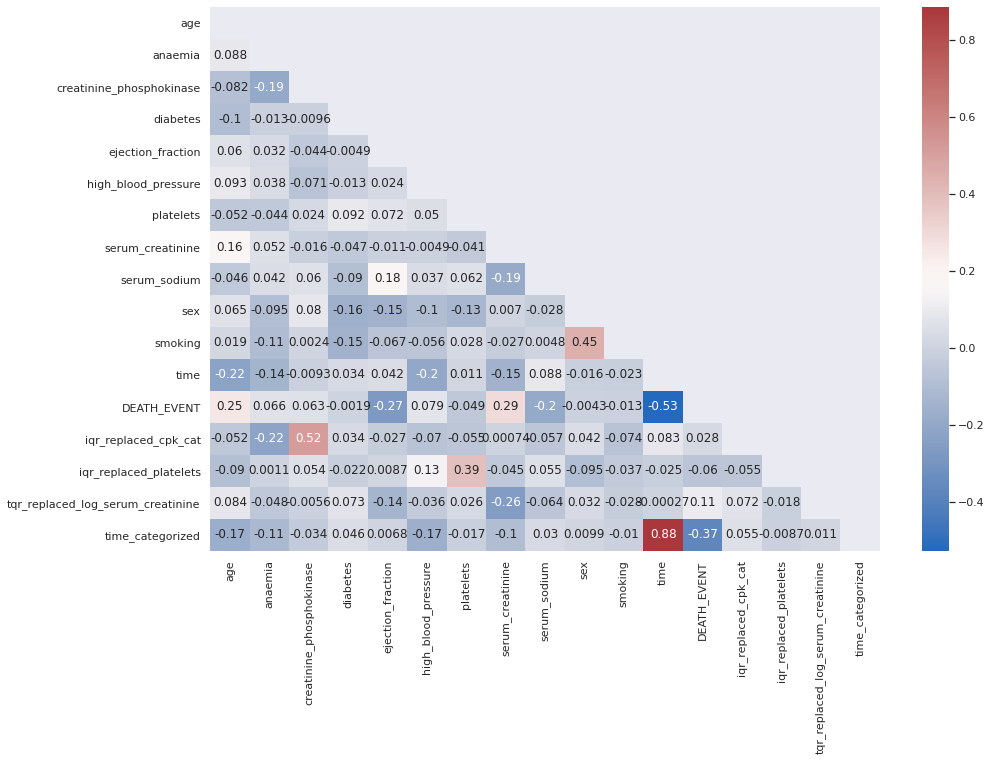

In [36]:
f, ax = plt.subplots(figsize=(15,10))
mask = np.triu(np.ones_like(data.corr(), dtype='bool'))
sns.heatmap(
    data = data.corr(),
    annot=True,
    cbar=True,
    mask=mask,
    cmap='vlag'
);

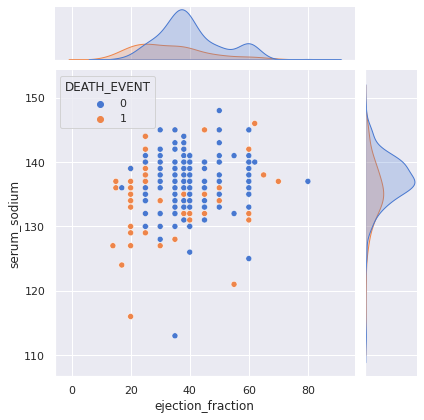

In [37]:
sns.jointplot(data=data, x='ejection_fraction', y='serum_sodium', hue='DEATH_EVENT');

- cases with greater serum_sodium and ejetion_fraction seems to have better survial rate.

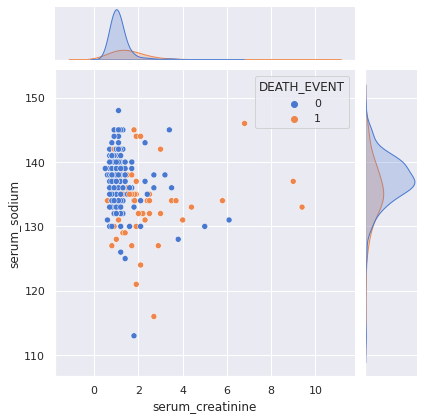

In [38]:
sns.jointplot(data=data, x='serum_creatinine', y='serum_sodium', hue='DEATH_EVENT');

- If the serum_sodium is <= 130, and serum_creatinine < ~1.8 ish, the rate of survival seems to be high.

# MultiVariate Analysis

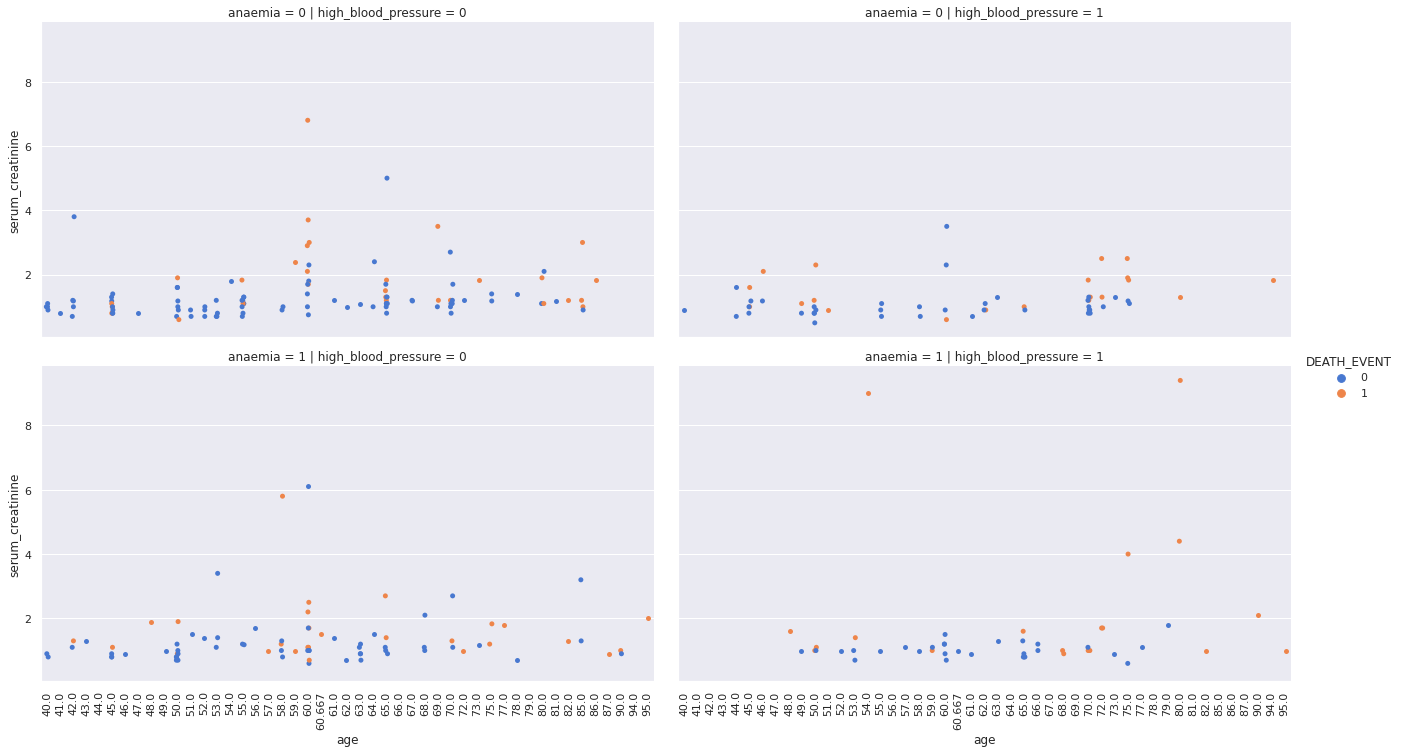

In [39]:
c = sns.catplot(
        y='serum_creatinine', 
        x='age',
        data=data,
        hue='DEATH_EVENT',
        col= 'high_blood_pressure',
        row= 'anaemia',
        aspect= 1.8
    )
c.set_xticklabels(rotation=90);

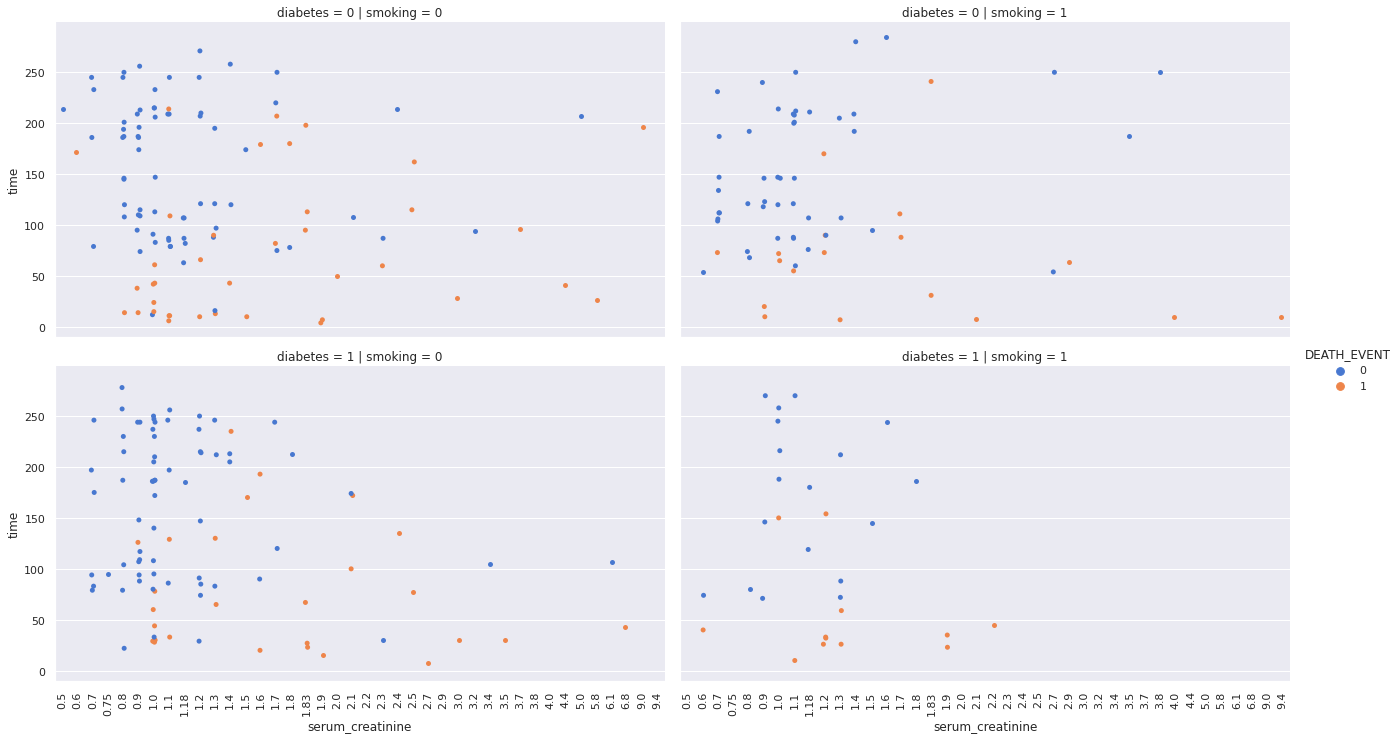

In [40]:
c = sns.catplot(
        x='serum_creatinine', 
        y='time',
        data=data,
        hue='DEATH_EVENT',
        col= 'smoking',
        row= 'diabetes',
        aspect= 1.8
    )
c.set_xticklabels(rotation=90);

- Generally, those with low serum_creatine levels survive more.
- Those with less follow up time survive less.
- Irrespective of whether there is diabeties, a combination of low serum_creatine levels and high follow up time tends to have better survival rate.

# Data Preparation

In [41]:
data_selected = data.iloc[:,[0,1,3,4,5,8,9,10,13,14,15,16,12]]
data_selected.head()

age  anaemia  diabetes  ejection_fraction  high_blood_pressure  \
0  75.0        0         0                 20                    1   
1  55.0        0         0                 38                    0   
2  65.0        0         0                 20                    0   
3  50.0        1         0                 20                    0   
4  65.0        1         1                 20                    0   

   serum_sodium  sex  smoking  iqr_replaced_cpk_cat  iqr_replaced_platelets  \
0           130    1        0                     1               265000.00   
1           136    1        0                     1               263358.03   
2           129    1        1                     0               162000.00   
3           137    1        0                     0               210000.00   
4           116    0        0                     0               327000.00   

   tqr_replaced_log_serum_creatinine  time_categorized  DEATH_EVENT  
0                           1.064711                 0            1  
1                           0.741937                 0            1  
2                           0.832909                 0            1  
3                           1.064711                 0            1  
4                           0.233615                 0            1

In [42]:
numerical_data = data_selected.iloc[:,[0,3,5,9,10]]
categorical_data = data_selected.iloc[:,[1,2,3,6,7,8,11,12]]
print("CATEGORICAL:->",categorical_data.columns)
print("\nNUMERICAL:->",numerical_data.columns)

CATEGORICAL:-> Index(['anaemia', 'diabetes', 'ejection_fraction', 'sex', 'smoking',
       'iqr_replaced_cpk_cat', 'time_categorized', 'DEATH_EVENT'],
      dtype='object')

NUMERICAL:-> Index(['age', 'ejection_fraction', 'serum_sodium', 'iqr_replaced_platelets',
       'tqr_replaced_log_serum_creatinine'],
      dtype='object')


In [43]:
s_scaler = StandardScaler()
numerical_data = pd.DataFrame(s_scaler.fit_transform(numerical_data), columns = numerical_data.columns)
numerical_data.head()

age  ejection_fraction  serum_sodium  iqr_replaced_platelets  \
0  1.192945          -1.530560     -1.504036                0.281065   
1 -0.491279          -0.007077     -0.141976                0.259921   
2  0.350833          -1.530560     -1.731046               -1.045306   
3 -0.912335          -1.530560      0.085034               -0.427191   
4  0.350833          -1.530560     -4.682176                1.079464   

   tqr_replaced_log_serum_creatinine  
0                           1.658802  
1                           0.119532  
2                           0.553366  
3                           1.658802  
4                          -2.304599

In [44]:
training_data_scaled = pd.concat([numerical_data,categorical_data],axis=1)

In [45]:
training_data_scaled.isnull().sum()

age                                  0
ejection_fraction                    0
serum_sodium                         0
iqr_replaced_platelets               0
tqr_replaced_log_serum_creatinine    0
anaemia                              0
diabetes                             0
ejection_fraction                    0
sex                                  0
smoking                              0
iqr_replaced_cpk_cat                 0
time_categorized                     0
DEATH_EVENT                          0
dtype: int64

In [46]:
#train set = 65% of the data
X_train, X_remaining, y_train, y_remaining = train_test_split(training_data_scaled.iloc[:,:-1], training_data_scaled.iloc[:,-1], random_state=123, test_size=0.35)

#validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, random_state=123, test_size=0.5)

# Model Building

**KNN Classifier**

In [47]:
int(np.round(np.sqrt(X_train.shape[0])))

14

Train: [0.8608247422680413, 0.8402061855670103, 0.7989690721649485, 0.788659793814433, 0.788659793814433, 0.788659793814433]
Test: [0.6792452830188679, 0.6226415094339622, 0.6792452830188679, 0.6792452830188679, 0.660377358490566, 0.660377358490566]


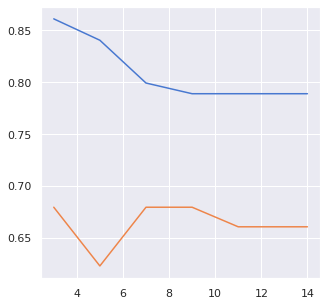

In [48]:
train_scores=[]
test_scores=[]
for k in [3,5,7,9,11,15]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_scores.append(knn.score(X_train, y_train))
    test_scores.append(knn.score(X_test, y_test))
f, ax1 = plt.subplots(figsize=(5,5))
sns.lineplot(x=[3,5,7,9,11,14], y=train_scores, ax=ax1)
sns.lineplot(x=[3,5,7,9,11,14], y=test_scores, ax=ax1)
print("Train:",train_scores)
print("Test:",test_scores)

In [49]:
def draw_confusion_matrix(y_test, y_pred):
    cf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=labels, fmt='', cmap='Blues');

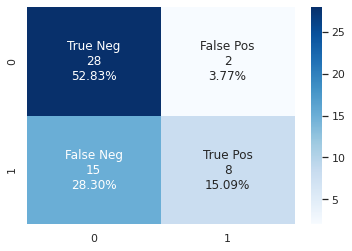

In [50]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
draw_confusion_matrix(y_test, y_pred)

In [51]:
pd.DataFrame(classification_report(y_pred, y_test, output_dict=True)).T

precision    recall  f1-score    support
0              0.933333  0.651163  0.767123  43.000000
1              0.347826  0.800000  0.484848  10.000000
accuracy       0.679245  0.679245  0.679245   0.679245
macro avg      0.640580  0.725581  0.625986  53.000000
weighted avg   0.822860  0.679245  0.713864  53.000000

**RadiusNeighborsClassifier**

Train: [0.7989690721649485, 0.7989690721649485, 0.7989690721649485, 0.7989690721649485, 0.7989690721649485, 0.7989690721649485]
Test: [0.6792452830188679, 0.6792452830188679, 0.6792452830188679, 0.6792452830188679, 0.6792452830188679, 0.6792452830188679]


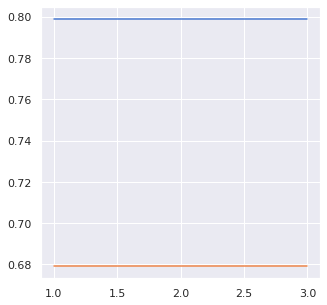

In [52]:
train_scores=[]
test_scores=[]
for rad in [1, 1.5, 1.7, 1.9, 2, 3]:
    RNC = RadiusNeighborsClassifier(radius=rad)
    RNC.fit(X_train, y_train)
    train_scores.append(knn.score(X_train, y_train))
    test_scores.append(knn.score(X_test, y_test))
f, ax1 = plt.subplots(figsize=(5,5))
sns.lineplot(x=[1, 1.5, 1.7, 1.9, 2, 3], y=train_scores, ax=ax1)
sns.lineplot(x=[1, 1.5, 1.7, 1.9, 2, 3], y=test_scores, ax=ax1)
print("Train:",train_scores)
print("Test:",test_scores)

<h3>Support Vector Classifier</h3>

In [53]:
param_grid = {
    'C': [0.5, 0.6, 0.75, 0.8, 0.85, 0.9],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2,3,4,5]
    }

In [54]:
svc = SVC() 

In [55]:
grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=True,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.5, 0.6, 0.75, 0.8, 0.85, 0.9],
                         'degree': [2, 3, 4, 5],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             return_train_score=True, scoring='neg_mean_squared_error')

In [56]:
grid_search.best_params_

{'C': 0.8, 'degree': 2, 'kernel': 'rbf'}

In [57]:
grid_search_results = pd.DataFrame(grid_search.cv_results_).iloc[:,[4,5,6,7,13,14,21,22]]
grid_search_results.mean_train_score = -1 * grid_search_results.mean_train_score
grid_search_results.mean_test_score = -1 * grid_search_results.mean_test_score
grid_search_results.sort_values(by=['mean_test_score','mean_train_score'], ascending=False).head()

param_C param_degree param_kernel  \
1     0.5            2         poly   
3     0.5            2      sigmoid   
5     0.5            3         poly   
7     0.5            3      sigmoid   
9     0.5            4         poly   

                                         params  mean_test_score  \
1     {'C': 0.5, 'degree': 2, 'kernel': 'poly'}         0.278273   
3  {'C': 0.5, 'degree': 2, 'kernel': 'sigmoid'}         0.278273   
5     {'C': 0.5, 'degree': 3, 'kernel': 'poly'}         0.278273   
7  {'C': 0.5, 'degree': 3, 'kernel': 'sigmoid'}         0.278273   
9     {'C': 0.5, 'degree': 4, 'kernel': 'poly'}         0.278273   

   std_test_score  mean_train_score  std_train_score  
1        0.007557          0.278346         0.001853  
3        0.007557          0.278346         0.001853  
5        0.007557          0.278346         0.001853  
7        0.007557          0.278346         0.001853  
9        0.007557          0.278346         0.001853

In [58]:
final_model = grid_search.best_estimator_
y_pred = final_model.predict(X_test)

In [59]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T

precision    recall  f1-score    support
0              0.591837  0.966667  0.734177  30.000000
1              0.750000  0.130435  0.222222  23.000000
accuracy       0.603774  0.603774  0.603774   0.603774
macro avg      0.670918  0.548551  0.478200  53.000000
weighted avg   0.660474  0.603774  0.512008  53.000000

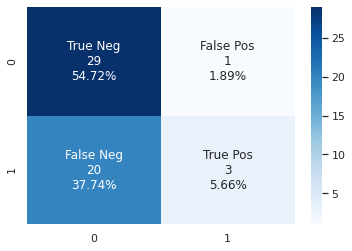

In [60]:
draw_confusion_matrix(y_test, y_pred)

# Decision Tree Classifier

In [61]:
dtree = DecisionTreeClassifier(criterion='gini', random_state=123)
dtree.fit(X_train, y_train)
print("Training Score [without Pruning]:", dtree.score(X_train, y_train))
print("Testing Score [without Pruning]:", dtree.score(X_test, y_test))

Training Score [without Pruning]: 1.0
Testing Score [without Pruning]: 0.6226415094339622


The decision tree overfit as expected.

In [62]:
path = dtree.cost_complexity_pruning_path(X_train, y_train)

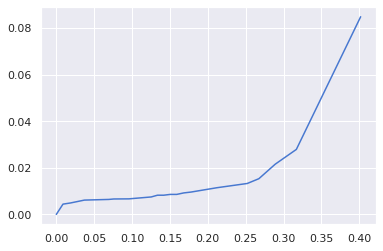

In [63]:
sns.lineplot(path['impurities'],path['ccp_alphas']);

**----------------Pruning----------------**

In [64]:
dtree2 = DecisionTreeClassifier(
    criterion='gini', 
    random_state=123, 
    min_samples_leaf=5, 
    ccp_alpha=0.027, 
    max_depth=5)
dtree2.fit(X_train, y_train)
print("Training Score [with Pruning]:", dtree2.score(X_train, y_train))
print("Testing Score [with Pruning]:", dtree2.score(X_test, y_test))

Training Score [with Pruning]: 0.8144329896907216
Testing Score [with Pruning]: 0.7547169811320755


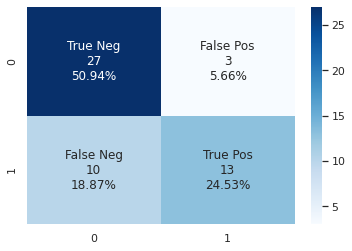

In [65]:
y_pred = dtree2.predict(X_test)
draw_confusion_matrix(y_test, y_pred)

In [66]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T

precision    recall  f1-score    support
0              0.729730  0.900000  0.805970  30.000000
1              0.812500  0.565217  0.666667  23.000000
accuracy       0.754717  0.754717  0.754717   0.754717
macro avg      0.771115  0.732609  0.736318  53.000000
weighted avg   0.765649  0.754717  0.745518  53.000000

<h3>AdaBoost Classifier</h3>

In [67]:
ada = AdaBoostClassifier(
    base_estimator = DecisionTreeClassifier(
    criterion='gini', 
    random_state=123, 
    min_samples_leaf=20, 
    ccp_alpha=0.0282, 
    max_depth=5),
    
    n_estimators = 120,
    random_state = 123,
    algorithm='SAMME'
)

In [68]:
ada.fit(X_train, y_train)
print("Train Score:", ada.score(X_train, y_train))
print("Test Score:", ada.score(X_test, y_test))

Train Score: 0.8247422680412371
Test Score: 0.7547169811320755


In [69]:
y_pred = ada.predict(X_test)

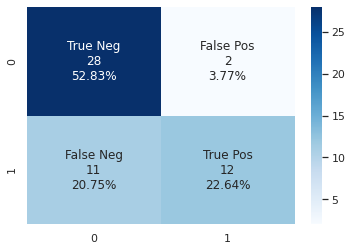

In [70]:
draw_confusion_matrix(y_test, y_pred)

In [71]:
pd.DataFrame(classification_report(y_pred, y_test, output_dict=True)).T

precision    recall  f1-score    support
0              0.933333  0.717949  0.811594  39.000000
1              0.521739  0.857143  0.648649  14.000000
accuracy       0.754717  0.754717  0.754717   0.754717
macro avg      0.727536  0.787546  0.730121  53.000000
weighted avg   0.824610  0.754717  0.768552  53.000000

<h3>Random Forest Classifier</h3>

In [72]:
rf = RandomForestClassifier(
    n_estimators=120,
    criterion='gini',
    ccp_alpha=0.0282,
    max_depth=5,
    min_samples_leaf=5,
    random_state=123,
    oob_score=True
)

In [73]:
rf.fit(X_train, y_train)
print("Train Score:", rf.score(X_train, y_train))
print("Test Score:", rf.score(X_test, y_test))

Train Score: 0.8144329896907216
Test Score: 0.6037735849056604


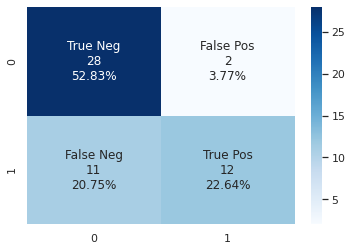

In [74]:
y_pred = ada.predict(X_test)
draw_confusion_matrix(y_test, y_pred)

In [75]:
pd.DataFrame(classification_report(y_pred, y_test, output_dict=True)).T

precision    recall  f1-score    support
0              0.933333  0.717949  0.811594  39.000000
1              0.521739  0.857143  0.648649  14.000000
accuracy       0.754717  0.754717  0.754717   0.754717
macro avg      0.727536  0.787546  0.730121  53.000000
weighted avg   0.824610  0.754717  0.768552  53.000000